# メイン2

## 昨日のレース結果を更新する

In [798]:
# 最新のレース結果をダウンロードする
import download_race_data as dl_race
import importlib
import datetime as dt
importlib.reload(dl_race)

# start_date = dt.datetime.strptime('2022-11-01', '%Y-%m-%d')
start_date = dt.datetime.strptime('2023-01-01', '%Y-%m-%d')

yesterday_date = dt.datetime.now() - dt.timedelta(1)
dl_race.download_race_data(start_date, yesterday_date)

# テストを実行
dl_race.test()

# テーブルを作成
import create_tables
importlib.reload(create_tables)

data_tables = create_tables.DataTables.create_with_update() # need_update (最新のtxtを既存のpickleのテーブルをくっつける)
# data_tables = create_tables.DataTables.create_with_all_update() # テーブル構造を変えたときや一番はじめはこっちを実行

# テストを実行
data_tables.test()


download_race_data: テスト成功
create_tables:テスト成功


In [680]:
# テーブルを表示確認
# data_tables.merged_t

## ここからシミュレーションプログラム

In [714]:
import race_results as rr
import return_table as rt
import syusso_table as sy
import model_evaluator as mev
import importlib
import create_tables
import utils
import racer_table as racer_t 
importlib.reload(rt)
importlib.reload(create_tables)
importlib.reload(rr)
importlib.reload(rt)
importlib.reload(sy)
importlib.reload(mev)
importlib.reload(utils)
importlib.reload(racer_t)

data_tables = create_tables.DataTables.create()

race_results = rr.RaceResults(data_tables.merged_t)
return_table = rt.ReturnTable(data_tables.return_t)

race_d = race_results.generate_categorical()

# 会場で絞ってみる 
race_d = utils.filter_stadium(race_d, 'OMR')

In [716]:
import utils
importlib.reload(utils)


# レース結果を訓練データと予測データに分けてシミュレーション
train, test = utils.split_data(race_d)

# X_train = train.drop(["rank"], axis=1)
# y_train = train["rank"]
# X_test = test.drop(["rank"], axis=1)
# y_test = test["rank"]
X_train = train.drop(["rank", "艇番", "日付"], axis=1)
y_train = train["rank"]
X_test = test.drop(["rank", "艇番", "日付"], axis=1)
y_test = test["rank"]

#LightGBMによる予測モデル作成
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

params = {
    "num_leaves": 4,
    "n_estimators": 80,
    "class_weight": "balanced",
    "random_state": 100,
}
lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values)

# me_t.score(y_test, X_test)

LGBMClassifier(class_weight='balanced', n_estimators=80, num_leaves=4,
               random_state=100)

In [717]:
importlib.reload(mev)
me_f= mev.ModelEvaluator(lgb_clf, return_table.data_p, std=False)
me_t = mev.ModelEvaluator(lgb_clf, return_table.data_p, std=True)

In [686]:
# predテーブルの表示
# me_t.pred_table(X_test, test, 0.5, False)

In [737]:
# 実際のレースの出走テーブルの作成
import syusso_table as sy
importlib.reload(sy)
syusso = sy.SyussoTable(race_results, '20230106', 'OMR')
syusso.test()
syusso_d = syusso.generate_categorical()

20230106OMR01 直前情報リクエスト済みなのでスキップ
20230106OMR02 直前情報リクエスト済みなのでスキップ
20230106OMR03 直前情報リクエスト済みなのでスキップ
20230106OMR04 直前情報リクエスト済みなのでスキップ
20230106OMR05 直前情報リクエスト済みなのでスキップ
20230106OMR06 直前情報リクエスト済みなのでスキップ
20230106OMR07 直前情報リクエスト済みなのでスキップ
20230106OMR08 直前情報リクエスト済みなのでスキップ
20230106OMR09 直前情報リクエスト済みなのでスキップ
20230106OMR10 直前情報リクエスト済みなのでスキップ
20230106OMR11 直前情報リクエスト済みなのでスキップ
20230106OMR12 直前情報リクエスト済みなのでスキップ
レーサーの過去生成データテーブルの作成


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 45.51it/s]


syusso_table:テスト成功


In [739]:
# 実際の出走テーブルを使って予測しpredテーブルを表示
# me_t.pred_table(syusso_d.drop(['艇番'], axis=1), syusso_d, 0.7, False)

In [246]:
# 行数省略用ユーティリティ
# utils.begin_display_row_num()
# utils.end_display_row_num()

In [795]:
# フューチャーインポータんすの表示
# me_t.feature_importance(X_test)

In [741]:
# テストモデルのレース数 / 6船 = 1レースに1枚買った枚数
# それに0.7(適当)掛けた枚数を最低購入数とする
min_buy_num = len(X_test.index.unique())/6 * 0.5
print("全データ数", len(race_results.data_p))
print("平和島全データ数", len(race_d))
print("テストデータ数", len(X_test))
print("レース数", len(X_test.index.unique()))
print("1レースに1舟券掛けたら買う枚数", len(X_test.index.unique())/6)
print("最低購入枚数", min_buy_num)

gain_f = mev.Gain(me_f, X_test, test, return_table.data_p, lower=min_buy_num, n_samples=100)
gain_t = mev.Gain(me_t, X_test, test, return_table.data_p, lower=min_buy_num, n_samples=100)

全データ数 660764
平和島全データ数 28586
テストデータ数 8577
レース数 1451
1レースに1舟券掛けたら買う枚数 241.83333333333334
最低購入枚数 120.91666666666667


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.16it/s]


In [744]:
importlib.reload(mev)
gain_f_tansho = gain_f.calc_return(mev.win_return)
gain_f_fukusho = gain_f.calc_return(mev.place_return)
gain_t_tansho = gain_t.calc_return(mev.win_return)
gain_t_fukusho = gain_t.calc_return(mev.place_return)
gain_t_exacta = gain_t.calc_return(mev.exacta_return)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.42it/s]


<AxesSubplot: >

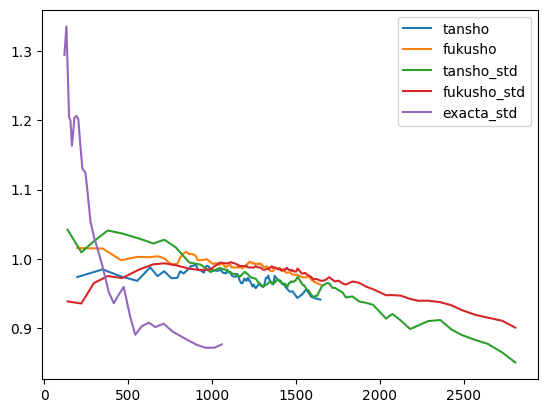

In [745]:
gain_f_tansho.rename('tansho').plot(legend=True)
gain_f_fukusho.rename('fukusho').plot(legend=True)
gain_t_tansho.rename('tansho_std').plot(legend=True)
gain_t_fukusho.rename('fukusho_std').plot(legend=True)
gain_t_exacta.rename('exacta_std').plot(legend=True)

In [746]:
# 回収率の最大値
gain_t_tansho.max()

1.042142857142857

## 実験

In [799]:
import syusso_table as sy
import utils 
importlib.reload(sy)
importlib.reload(utils)

syusso = sy.SyussoTable(race_results, '20230105', 'OMR')
syusso.test()

20230105OMR01 直前情報リクエスト済みなのでスキップ
20230105OMR02 直前情報リクエスト済みなのでスキップ
20230105OMR03 直前情報リクエスト済みなのでスキップ
20230105OMR04 直前情報リクエスト済みなのでスキップ
20230105OMR05 直前情報リクエスト済みなのでスキップ
20230105OMR06 直前情報リクエスト済みなのでスキップ
20230105OMR07 直前情報リクエスト済みなのでスキップ
20230105OMR08 直前情報リクエスト済みなのでスキップ
20230105OMR09 直前情報リクエスト済みなのでスキップ
20230105OMR10 直前情報リクエスト済みなのでスキップ
20230105OMR11 直前情報リクエスト済みなのでスキップ
20230105OMR12 直前情報リクエスト済みなのでスキップ
syusso_table:テスト成功


In [800]:
# レーサーの過去テーブル作成テスト用(出走テーブルのデータをもとに作るのが処理時間が短くて確認しやすい
import racer_table as racer_t
importlib.reload(racer_t)

# hoge = racer_t.RacerTable.create_from_syusso(data_tables.race_t, syusso.data)
hoge = racer_t.RacerTable.create_from_syusso(syusso.race_results.data, syusso.data)
hoge.data_p

レーサーの過去生成データテーブルの作成


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 69.25it/s]


,レースコード,艇番,全国_1着率_allR,全国_3着率_allR,全国_着順平均_allR,全国_スタートタイミング_allR,全国_展示タイム_allR,当地_1着率_allR,当地_3着率_allR,当地_着順平均_allR,...,当地_1着率_5R,当地_3着率_5R,当地_着順平均_5R,当地_スタートタイミング_5R,当地_展示タイム_5R,コース別_1着率_5R,コース別_3着率_5R,コース別_着順平均_5R,コース別_スタートタイミング_5R,コース別_展示タイム_5R
0,20230105OMR01,1,0.138122,0.464088,3.417127,0.188483,6.819607,0.0,0.0,NaN,...,0.0,0.0,NaN,NaN,NaN,0.4,1.0,1.8,0.170,6.758
50,20230105OMR09,3,0.137741,0.465565,3.413223,0.188263,6.819916,0.0,0.0,NaN,...,0.0,0.0,NaN,NaN,NaN,0.0,0.8,2.6,0.226,6.846
1,20230105OMR01,2,0.076923,0.381538,3.778462,0.155556,6.829630,0.0,0.0,NaN,...,0.0,0.0,NaN,NaN,NaN,0.2,0.6,3.0,0.124,6.848
66,20230105OMR12,1,0.076687,0.380368,3.779141,0.155785,6.829846,0.0,0.0,NaN,...,0.0,0.0,NaN,NaN,NaN,0.2,0.8,2.4,0.186,6.818
2,20230105OMR01,3,0.248101,0.521519,3.288608,0.150128,6.873189,0.0,0.0,NaN,...,0.0,0.0,NaN,NaN,NaN,0.2,0.6,3.0,0.206,6.920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,20230105OMR12,3,0.286972,0.702465,2.691901,0.152852,6.784683,0.0,0.0,NaN,...,0.0,0.0,NaN,NaN,NaN,0.6,1.0,1.8,0.174,6.806
46,20230105OMR08,5,0.139108,0.485564,3.425197,0.179474,6.799921,0.0,0.0,NaN,...,0.0,0.0,NaN,NaN,NaN,0.0,0.2,4.2,0.220,6.832
47,20230105OMR08,6,0.144165,0.443936,3.686499,0.131648,6.794371,0.0,0.0,NaN,...,0.0,0.0,NaN,NaN,NaN,0.0,0.4,4.4,0.128,6.740
53,20230105OMR09,6,0.171698,0.584906,3.232075,0.170586,6.821096,0.0,0.0,NaN,...,0.0,0.0,NaN,NaN,NaN,0.0,0.2,4.6,0.244,6.810
